In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score


In [2]:
# دیکشنری شیت‌های هزینه
p3_sheets = {
    'Food': 'Food',
    'Tobacco': 'Tobacco',
    'Clothing': 'Clothing',
    'Housing': 'Housing',
    'Furniture': 'Furniture',
    'Health': 'Health',
    'Transport': 'Transport',
    'Communication': 'Communication',
    'Recreation': 'Recreation',
    'Education': 'Education',
    'Hotel': 'Hotel',
    'Miscellaneous': 'Miscellaneous',
    'Investment': 'Investment'
}

In [3]:
def read_expenditure_data(file_prefix, year):
    file_name = f'{file_prefix}{year}_cleaned.xlsx'
    expenditure_data_list = []

    # استفاده از نام شیت‌های واقعی در فایل اکسل
    for sheet_name in p3_sheets.keys():
        try:
            df = pd.read_excel(file_name, sheet_name=sheet_name)
            if 'Address' in df.columns and ('value' in df.columns or 'Value' in df.columns):
                value_column = 'value' if 'value' in df.columns else 'Value'
                df[value_column] = pd.to_numeric(df[value_column], errors='coerce').fillna(0)
                if sheet_name == 'Housing' and 'mortgage' in df.columns:
                    df['mortgage'] = pd.to_numeric(df['mortgage'], errors='coerce').fillna(0)
                    df['total_value'] = df[value_column] + df['mortgage']
                else:
                    df['total_value'] = df[value_column]
                df_grouped = df.groupby('Address')['total_value'].sum().reset_index()
                df_grouped.rename(columns={'total_value': f'Expenditure_{sheet_name}'}, inplace=True)
                expenditure_data_list.append(df_grouped)
            else:
                print(f'ستون‌های مورد نیاز در شیت {sheet_name} یافت نشدند.')
                continue
        except Exception as e:
            print(f'خطا در خواندن شیت {sheet_name}: {e}')
            continue

    # ادغام تمامی داده‌های هزینه‌ای
    if expenditure_data_list:
        expenditure_data = pd.concat(expenditure_data_list, axis=0, ignore_index=True)
        # جمع کردن هزینه‌ها برای هر Address
        expenditure_data = expenditure_data.groupby('Address').sum().reset_index()
        # محاسبه کل هزینه‌ها
        expenditure_columns = [col for col in expenditure_data.columns if col.startswith('Expenditure_')]
        expenditure_data['Expenditure'] = expenditure_data[expenditure_columns].sum(axis=1)
        return expenditure_data
    else:
        raise ValueError("No valid data to concatenate in expenditure sheets.")


In [4]:
def read_income_data(file_prefix, year):
    file_name = f'{file_prefix}{year}_cleaned.xlsx'
    income_sheets = [f'{file_prefix}{year}P4S01', f'{file_prefix}{year}P4S02', f'{file_prefix}{year}P4S03', f'{file_prefix}{year}P4S04']
    income_data_list = []
    for sheet_name in income_sheets:
        try:
            df = pd.read_excel(file_name, sheet_name=sheet_name)
            if 'Address' in df.columns:
                income_columns = []
                if sheet_name.endswith('P4S01'):
                    income_columns = ['income_w_y', 'wage_w_y', 'perk_w_y', 'netincome_w_y']
                elif sheet_name.endswith('P4S02'):
                    income_columns = ['income_s_y', 'sale']
                elif sheet_name.endswith('P4S03'):
                    income_columns = ['income_pension', 'income_rent', 'income_interest', 'income_aid', 'income_resale', 'income_transfer']
                elif sheet_name.endswith('P4S04'):
                    income_columns = ['subsidy']
                income_columns = [col for col in income_columns if col in df.columns]
                for col in income_columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
                df['Total_Income'] = df[income_columns].sum(axis=1)
                df_grouped = df.groupby('Address')['Total_Income'].sum().reset_index()
                income_data_list.append(df_grouped)
            else:
                print(f'ستون "Address" در شیت {sheet_name} یافت نشد.')
                continue
        except Exception as e:
            print(f'خطا در خواندن شیت {sheet_name}: {e}')
            continue
    if income_data_list:
        income_data = pd.concat(income_data_list, axis=0, ignore_index=True)
        income_data = income_data.groupby('Address').sum().reset_index()
        income_data.rename(columns={'Total_Income': 'Income'}, inplace=True)
        return income_data
    else:
        raise ValueError("No valid data to concatenate in income sheets.")



In [5]:
# لیست سال‌ها
years = [98, 99, 1400, 1401]

# لیست پیشوندهای فایل برای داده‌های شهری و روستایی
file_prefixes = ['U', 'R']

expenditure_data_list = []
income_data_list = []
household_data_list = []

In [6]:
for file_prefix in file_prefixes:
    for year in years:
        try:
            expenditure_data = read_expenditure_data(file_prefix, year)
            income_data = read_income_data(file_prefix, year)
            household_data = pd.read_excel(f'{file_prefix}{year}_cleaned.xlsx', sheet_name=f'{file_prefix}{year}Data')

            # اضافه کردن سال و نوع سکونت به داده‌ها
            expenditure_data['Year'] = 1300 + year
            income_data['Year'] = 1300 + year
            household_data['Year'] = 1300 + year
            household_data['Type'] = file_prefix  

            expenditure_data_list.append(expenditure_data)
            income_data_list.append(income_data)
            household_data_list.append(household_data)
        except Exception as e:
            print(f'خطا در پردازش فایل {file_prefix}{year}_cleaned.xlsx: {e}')
            continue

In [7]:
# ترکیب داده‌ها
all_expenditure_data = pd.concat(expenditure_data_list, ignore_index=True)
all_income_data = pd.concat(income_data_list, ignore_index=True)
all_household_data = pd.concat(household_data_list, ignore_index=True)

# ادغام داده‌ها
data = all_household_data.merge(all_income_data, on=['Address', 'Year'], how='left')
data = data.merge(all_expenditure_data, on=['Address', 'Year'], how='left')

In [8]:
# جایگزینی مقادیر NaN با صفر در درآمد و هزینه
data['Income'] = data['Income'].fillna(0)
data['Expenditure'] = data['Expenditure'].fillna(0)

# حذف خانوارهایی که درآمد و هزینه آنها صفر یا منفی است
data = data[(data['Income'] > 0) & (data['Expenditure'] > 0)]

# محاسبه لگاریتم درآمد و هزینه
data['Log_Income'] = np.log1p(data['Income'])
data['Log_Expenditure'] = np.log1p(data['Expenditure'])

In [9]:
# حذف مقادیر NaN
data = data.dropna(subset=['Log_Income', 'Log_Expenditure'])

# آماده‌سازی داده‌ها برای خوشه‌بندی
X = data[['Log_Income', 'Log_Expenditure']].values

# مقیاس‌دهی داده‌ها
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# حذف مقادیر پرت با استفاده از Z-Score
from scipy import stats
z_scores = np.abs(stats.zscore(X_scaled))
threshold = 3
mask = (z_scores < threshold).all(axis=1)
X_filtered = X_scaled[mask]
data_filtered = data[mask]

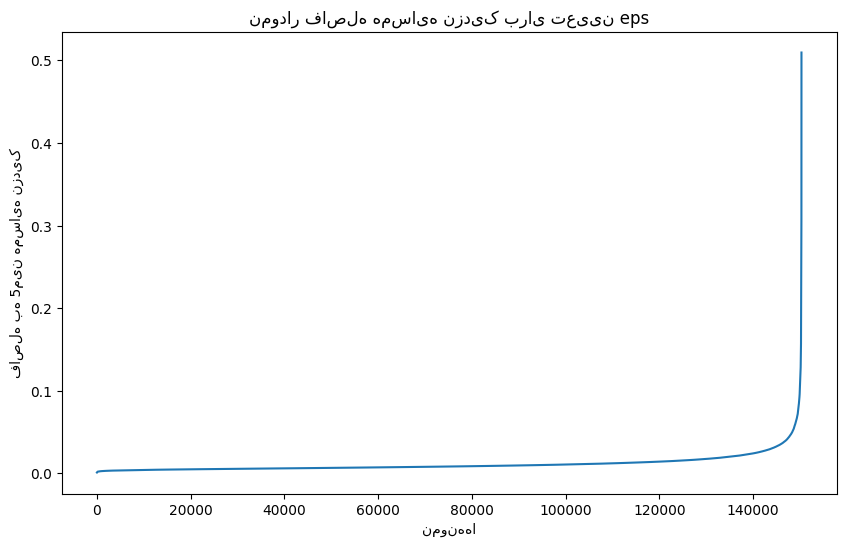

In [11]:
# تعیین مقدار eps با استفاده از نمودار فاصله همسایه نزدیک
min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_filtered)
distances, indices = neighbors_fit.kneighbors(X_filtered)
distances = np.sort(distances[:, min_samples - 1], axis=0)

# رسم نمودار فاصله همسایه نزدیک
plt.figure(figsize=(10,6))
plt.plot(distances)
plt.xlabel('نمونه‌ها')
plt.ylabel(f'فاصله به {min_samples}مین همسایه نزدیک')
plt.title('نمودار فاصله همسایه نزدیک برای تعیین eps')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_17036\2019560750.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['DBSCAN_Cluster'] = dbscan.labels_


تعداد خوشه‌های محاسبه‌شده: 1
تعداد نویز: 27


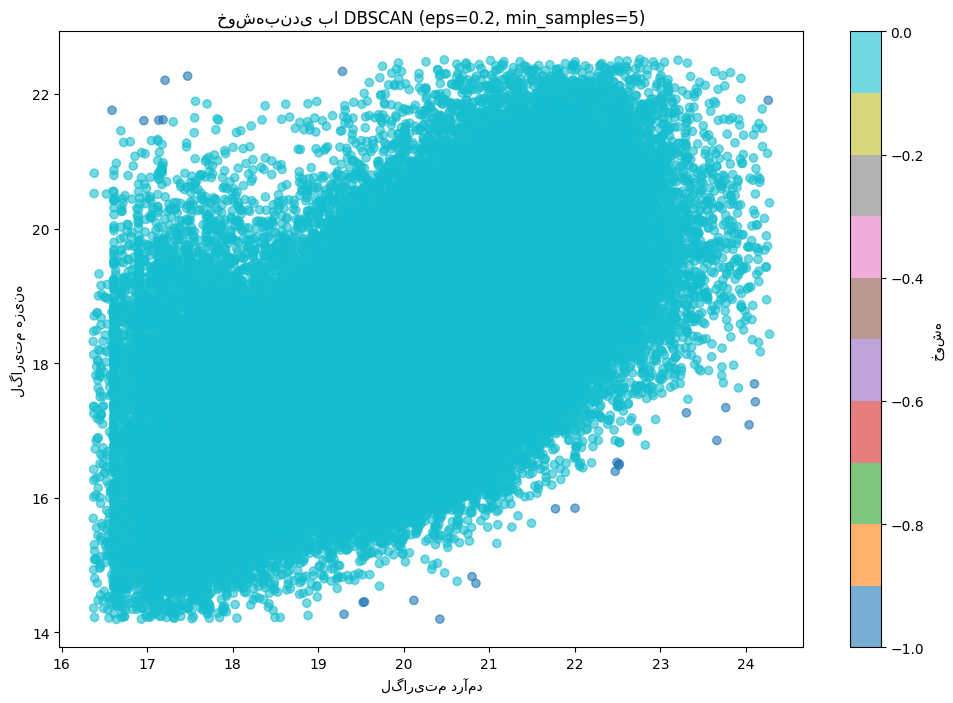

In [12]:
# انتخاب eps مناسب (مثلاً 0.2)
eps = 0.2

# اجرای الگوریتم DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(X_filtered)
data_filtered['DBSCAN_Cluster'] = dbscan.labels_

# محاسبه تعداد خوشه‌ها و نویز
n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
n_noise = list(dbscan.labels_).count(-1)
print(f"تعداد خوشه‌های محاسبه‌شده: {n_clusters}")
print(f"تعداد نویز: {n_noise}")

# رسم اسکتر پلات
plt.figure(figsize=(12,8))
scatter = plt.scatter(data_filtered['Log_Income'], data_filtered['Log_Expenditure'], c=data_filtered['DBSCAN_Cluster'], cmap='tab10', alpha=0.6)
plt.xlabel('لگاریتم درآمد')
plt.ylabel('لگاریتم هزینه')
plt.title(f'خوشه‌بندی با DBSCAN (eps={eps}, min_samples={min_samples})')
plt.colorbar(scatter, label='خوشه')
plt.show()

In [ ]:
# جستجوی بهترین ترکیب هایپرپارامترها
eps_values = np.arange(0.1, 0.5, 0.01)
min_samples_values = range(2, 11)

best_score = -1
best_params = {'eps': None, 'min_samples': None}
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_filtered)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters < 2:
            continue
        sil_score = silhouette_score(X_filtered[labels != -1], labels[labels != -1])
        results.append({'eps': eps, 'min_samples': min_samples, 'n_clusters': n_clusters, 'silhouette_score': sil_score})
        if sil_score > best_score and 8 <= n_clusters <= 12:
            best_score = sil_score
            best_params['eps'] = eps
            best_params['min_samples'] = min_samples
            best_params['n_clusters'] = n_clusters

In [ ]:
results_df = pd.DataFrame(results)
desired_clusters = results_df[(results_df['n_clusters'] >= 8) & (results_df['n_clusters'] <= 12)]
desired_clusters = desired_clusters.sort_values(by='silhouette_score', ascending=False)

# نمایش ۱۰ ترکیب برتر
print("۱۰ ترکیب برتر با تعداد خوشه‌های بین ۸ تا ۱۲:")
print(desired_clusters.head(10))